## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

### Load all test data into a singe dataframe

In [2]:
flutdf = pd.DataFrame()
b_modes = 3
t_modes = 3
dataset_name = 'HALE'
model_names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Lin0',6:'Free-IWT,FRotFWT,Lin0'}

for i in range(7):
    dat = pd.read_pickle(f'Eigen_{b_modes}B{t_modes}T-M{i}_{dataset_name}.pkl')
    dat['Model'] = i
    dat['Config'] = 'HALE'
    flutdf = flutdf.append(dat,sort=False)

flutdf = flutdf.reset_index(drop=True)

flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['sigma']*100)
flutdf['Coast Angle [Deg]'] = flutdf.apply(lambda row: np.rad2deg(row['q'][-1]),axis=1)
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))

flutdf['Model'] = pd.Categorical(flutdf['Model'])
flutdf['Config'] = pd.Categorical(flutdf['Config'])
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])

In [3]:
flutdf['FWT Mass [%]'].cat.categories

Float64Index([50.0, 100.0, 150.0], dtype='float64')

In [4]:
def iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True
    
def SeriesFilter(series,var):
    if var is None:
        return series == series
    elif iterable(var):
        return series.isin(var)
    else:
        return series == var

def GetReducedDataSet(flutdf,model_num,Flare=25,AoA=0,ratio_FWT=20,FWT_mass = 100,Vmin = 1,Vmax = 140,Modes=None):
    data = flutdf.copy()
    data = data[SeriesFilter(data['Model'],model_num)]
    data = data[SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[SeriesFilter(data['AoA [Deg]'],AoA)]
    data = data[SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[SeriesFilter(data['FWT Ratio [%]'],ratio_FWT)]
    data = data[SeriesFilter(data['Mode'],Modes)]
    data = data[data['V']<=Vmax]
    data = data[data['V']>=Vmin]
    return data

In [5]:
d = GetReducedDataSet(flutdf,[4])
d.head()

,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,Lambda,V,alpha_r,...,delta_m,q,Model,Config,Damping [%],FWT Mass [%],FWT Ratio [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg]
401202,-0.047476,0.151189,0.025221,-0.299595,True,[(2.7562843311342776e-05+5.696251421427717e-06...,0,0.436332,1.0,0.0,...,1.0,"[-0.02260190012510814, 0.0009809911490913559, ...",4,HALE,29.959526,100.0,20.0,89.682661,25.0,0.0
401203,-0.175920,3.126278,0.498350,-0.056183,True,[(-0.0004404646498922285-0.006882031660928613j...,1,0.436332,1.0,0.0,...,1.0,"[-0.02260190012510814, 0.0009809911490913559, ...",4,HALE,5.618260,100.0,20.0,89.682661,25.0,0.0
401204,-0.178851,20.086785,3.197038,-0.008904,True,[(-8.168086866058119e-05-0.008858761045206177j...,2,0.436332,1.0,0.0,...,1.0,"[-0.02260190012510814, 0.0009809911490913559, ...",4,HALE,0.890355,100.0,20.0,89.682661,25.0,0.0
401205,-0.106591,49.079243,7.811223,-0.002172,True,[(2.7464507218828873e-09-1.1078409206560503e-0...,3,0.436332,1.0,0.0,...,1.0,"[-0.02260190012510814, 0.0009809911490913559, ...",4,HALE,0.217182,100.0,20.0,89.682661,25.0,0.0
401206,-0.174846,95.575952,15.211411,-0.001829,True,[(4.643252146942704e-06+0.0026611565523866738j...,4,0.436332,1.0,0.0,...,1.0,"[-0.02260190012510814, 0.0009809911490913559, ...",4,HALE,0.182939,100.0,20.0,89.682661,25.0,0.0


In [6]:
def PlotLines(data,Modes,hue,var,ax,sigma=8,legend=True):
    for i in Modes:
        ax.set_prop_cycle(None)
        dat = data[data['Mode']==i]
        unique_vars = np.unique(dat[hue])
        for j in unique_vars:
            dat_test = dat[dat[hue]==j]
            y = dat_test[var].to_numpy()            
            #clean up jumps in data
            ind = []
            for k in range(2,len(y)):
                delta_1 = np.abs(y[k]-y[k-1])
                delta_2 = np.abs(y[k-2]-y[k-1])       
                if (delta_2*sigma <delta_1):
                    ind.append(k-1)
            for index in ind:
                y[index] = np.NaN
            
            v = dat_test['V'].to_numpy()
            ax.plot(v,y)
        

def CoastDeltaPlot(data,hue, ax,Delta = True):# testNums,ax,Flare=25,AoA=0,FWT_ratio = 20,FWT_mass = 100,Vmax=140,Delta = True):
    # plot Coast Angle Changes
    dataMode0 =data[data['Mode']==0]
    unique_vars = np.unique(data[hue])
    
    a_1 = data[data[hue]==unique_vars[0]]['Coast Angle [Deg]'].to_numpy()
    v_1 = data[data[hue]==unique_vars[0]]['V'].to_numpy()
    a_2 = data[data[hue]==unique_vars[1]]['Coast Angle [Deg]'].to_numpy()
    v_2 = data[data[hue]==unique_vars[1]]['V'].to_numpy()
    
    vs = np.linspace(0,np.max(v_1),100)
    delta = np.interp(vs,v_1,a_1) - np.interp(vs,v_2,a_2)
    
    ax.plot(v_1,a_1)
    ax.plot(v_2,a_2)
    ax.set_ylabel('Coast Angle [Deg]')
    ax.set_xlabel('Velocity [m/s]')
    if Delta:
        ax2 = ax.twinx()
        ax2.set_ylabel('Delta Coast Angle [Deg]',color='r')
        ax2.plot(vs,delta,'r--')
        ax2.tick_params(axis='y', labelcolor='r')

## Compare Tests

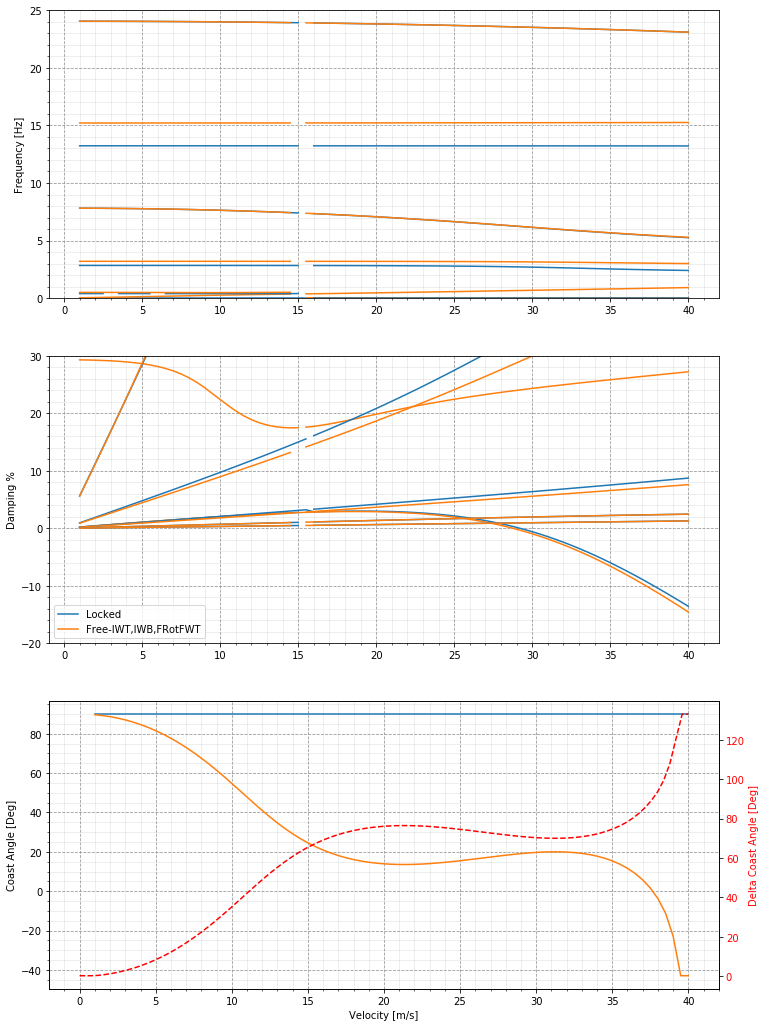

In [40]:
fig, axes = plt.subplots(3,1,figsize=(12,18))    

Tests = [0,4]
data = GetReducedDataSet(flutdf,Tests,Flare = 25,AoA=10,Vmax = 40)

PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'Model',var = 'Frequency',ax = axes[0])
PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'Model',var = 'Damping [%]',ax = axes[1])
CoastDeltaPlot(data,'Model', axes[2],Delta = True)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,140))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,25))
axes[1].set(ylim=(-20,30))    


#PlotModes(data,'Test',axes[:])
axes[1].legend([model_names[i] for i in Tests])
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

## Compare FWT Ratios

Text(0.5, 0, 'Velocity [m/s]')

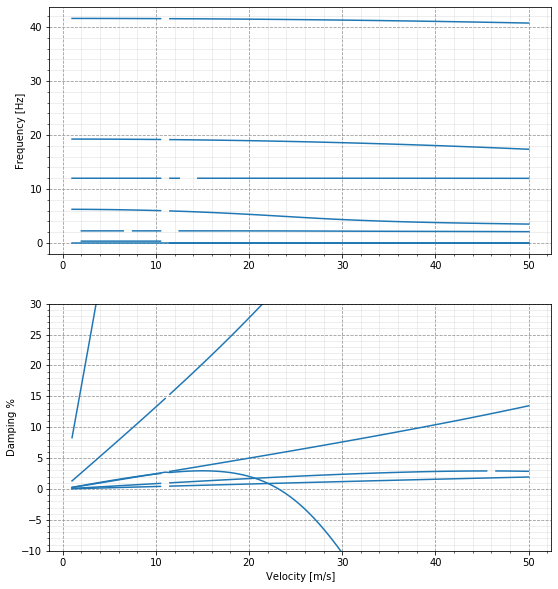

In [25]:
fig, axes = plt.subplots(2,1,figsize=(9,10))    

Tests = [0,4]
data = GetReducedDataSet(flutdf,0,ratio_FWT=[0], Flare = 25,Vmax=50,Modes=None)

#sns.scatterplot(data = data,x='V',y='Frequency',ax=axes[0],s=10,edgecolor='none')
#sns.scatterplot(data = data,x='V',y='Damping [%]',ax=axes[1],s=10,edgecolor='none')

PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'Model',var = 'Frequency',ax = axes[0],sigma=5)
PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'Model',var = 'Damping [%]',ax = axes[1],sigma=5)

for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,140))
    #axes[i].set_xticks([i*20 for i in range(11)])
#axes[0].set(ylim=(0.5,3))
#axes[0].set(ylim=(0,10))
axes[1].set(ylim=(-10,30))    


axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')
axes[1].set_xlabel('Velocity [m/s]')

#PlotModes(data,'Test',axes[:])
#axes[1].legend(['0%']*2+['10%']*2+['20%']*2,'30%'])
#axes[1].legend([model_names[i] for i in Tests])
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

In [146]:
a = [0,1,6,4,1,4]
np.unique(flutdf[flutdf['Mode']==1]['Test'])

array([0, 1, 2, 3, 4, 5, 6])